# Лабораторная работа 4. Рекомендательные системы, категориальные признаки и адаптивные методы обучения

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_03.ipynb.

## Рекомендательные системы и категориальные признаки

В этой части лабораторной работы мы рассмотрим и сравним несколько различных стратегий для решения задачи рекоммендаций:
- Most popular
- Memory based
- Matrix factorization
- Categorical features based approach
- Statistics features based approach

Вам нужно будет провести много экспериментов, поэтому приготовьтесь.

![](https://i.imgur.com/jwyaLjP.jpg)

### Про данные

В этой лабораторной работе будет рассмотрена задача предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Мы будем работать с датасетом [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают целые значения в интервале от 1 до 5, они записаны в файле *user_ratedmovies.dat* (а так же в *user_ratedmovies-timestamps.dat*,  где для каждой оценки дата и время записаны в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать в качестве признаков.
Заметьте: кроме оценок (и тегов), которые пользователь поставил фильмам, про пользователя ничего не известно.

На основании этих данных необходимо построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

### Про оценку качества рекомендаций

Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов этого пользователя $R^u_{test}$ рассмотрим три рейтинга, поставленные последними по времени. Остальные известные рейтинги будут составлять обучающую выборку $R^u_{train}$. Тогда все известные рейтинги можно представить как $R^u=R^u_{train}\cup R^u_{test}$. Отсутствующие оценки обозначим за $R^u_{unknown}$. 

Для измерения качества рекомендаций в этой лабораторной работе используйте две метрики RMSE и MAP, описанные ниже.

#### RMSE

Метрика [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) вычисляется следующим образом:
$$ RMSE = \sqrt{ \frac{1}{\left|R_{test}\right|} \sum_{(u,i) \in R_{test}} (r_{ui} - \hat{r}_{ui})^2 },$$
где $r_{ui}$ — наблюдаемая (правильная) оценка, а $\hat{r}_{ui}$ — оценка, предсказанная моделью.

Метрика RMSE предназначена для оценки точности предсказания, ее удобно оптимизировать напрямую. Однако, нужно учесть, что RMSE не лучший кандидат для оценки качества рекомендаций:
- Во-первых, RMSE оценивает точность предсказания рейтингов, что в задачах рекомендаций, как правило, менее важно, нежели верное ранжирование объектов (безотносительно абсолютных значений рейтингов). На практике часто бывает, что алгоритмы с худшим RMSE в продакшене работают лучше, чем алгоритмы с меньшим значением RMSE. Например, при использовании моделей рекомендаций на основе матричных разложений, заполнение отсутствующих оценок нулями имеет имеет худшее значение RMSE, чем если бы эти оценки не учитывались совсем, но при этом часто сами рекомендации становятся лучше по онлайн метрикам. 
- Во-вторых, RMSE одинаково штрафует точность предсказания оценок более популярных фильмов (которые попадут в блок рекомендаций) и менее популярных фильмов (длинный хвост из нерелевантных фильмов).

#### MAP

Для оценки качества рекомендаций можно использовать метрики качества ранжирования. В этом случае для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и $R^u_{unknown}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Обозначим позиции объектов в этом списке за $k^u_i$.

Назовем релевантными те фильмы, которые входят в $R^u_{test}$ и имеют оценку $\ge 3$. Обозначим их за $Rel^u$. Тогда можно вычислить следующую метрику качества рекомендаций для одного пользователя:

$$AP^u=\frac{1}{|Rel^u|} \sum_{(u,i) \in Rel^u} \frac{1}{k^u_i}.$$

Усреднив значение этой метрики по всем пользователями, мы получим окончательное значение метрики MAP. Пользователей без релевантных фильмов в тестовой выборке можно не учитывать.

#### Другие способы оценки качества рекомендаций

На практике, как правило, качество рекомендательных систем оценивается в онлайне с помощью [A/B-тестирования](https://en.wikipedia.org/wiki/A/B_testing).

## Коллаборативная фильтрация

- Загрузите данные и создайте разреженную матрицу оценок, где на пересечении $i$-ой строки и $j$-ого столбца стоит рейтинг, который пользователь под номером $i$ поставил фильму под номером $j$, если рейтинг известен, либо ноль, если неизвестен.
- Разбейте данные на обучающую и тестовую выборки. В качестве тестовых рейтингов для каждого пользователя возьмите три рейтинга, поставленные последними по времени. Остальные известные рейтинги будут составлять обучающую выборку.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


In [3]:
directory = 'hetrec2011-movielens-2k-v2'
data1 = pd.read_csv(directory +'/user_ratedmovies-timestamps.dat', sep='\t')
data2 = pd.read_csv(directory +'/movie_actors.dat', sep='\t', encoding='latin1')
data3 = pd.read_csv(directory +'/movie_countries.dat', sep='\t', encoding='latin1')
data4 = pd.read_csv(directory +'/movie_directors.dat', sep='\t', encoding='latin1')
data5 = pd.read_csv(directory +'/movie_genres.dat', sep='\t', encoding='latin1')
data6 = pd.read_csv(directory +'/movie_locations.dat', sep='\t', encoding='latin1')

data7 = pd.read_csv(directory +'/movie_tags.dat', sep='\t', encoding='latin1')
data8 = pd.read_csv(directory +'/movies.dat', sep='\t', encoding='latin1')
data9 = pd.read_csv(directory +'/tags.dat', sep='\t', encoding='latin1')
data10 = pd.read_csv(directory +'/user_taggedmovies-timestamps.dat', encoding='latin1', sep='\t')

составим из этого всего словарик по фильмам и матрицу пользователь - фильм

data6 не буру - это локации, в которых снимались фильмы - ну, кажется, не сильно важно.

data7 тоже не рассматриваю - это теги. Их чуть меньше, чем фильмов, поэтому врядли они информативны. Кроме того, я не понимаю, что это

data9 - тоже не беру - не понятно, что такое теги и как они должны влиять

data8 - беру 4 оценки - оценка критиков, кол-во критиков, оценка аудитории и кол-ва человек в аудитории. Отсюда также беру год фильма

data10 - опять теги (

In [4]:
from collections import defaultdict

films_meta = defaultdict(lambda : dict())

for i in range(len(data2)):
    if 'actors' in films_meta[data2.iloc[i].movieID].keys():
        films_meta[data2.iloc[i].movieID]['actors'] += [(data2.iloc[i].actorID, data2.iloc[i].ranking)]
    else:
        films_meta[data2.iloc[i].movieID]['actors'] = [(data2.iloc[i].actorID, data2.iloc[i].ranking)]
     

In [8]:
for i in range(len(data3)):
    films_meta[data3.iloc[i].movieID]['country'] = data3.iloc[i].country

for i in range(len(data4)):
    films_meta[data4.iloc[i].movieID]['director'] = data4.iloc[i].directorID
    
unique_genres = np.unique(data5.genre)
dict_id_genres = dict(zip(unique_genres, np.arange(len(unique_genres))))

for i in range(len(data5)):
    films_meta[data5.iloc[i].movieID]['genre'] = dict_id_genres[data5.iloc[i].genre]
    
for i in range(len(data8)):
    scores_array = np.array([data8.iloc[i].rtTopCriticsRating, data8.iloc[i].rtTopCriticsNumReviews, 
                    data8.iloc[i].rtAudienceRating, data8.iloc[i].rtAudienceNumRatings])
    scores_array[scores_array == '\\N'] = -1
    scores_array = scores_array.astype(float)

    films_meta[data8.iloc[i].id]['scores'] = list(scores_array)
    films_meta[data8.iloc[i].id]['year'] = int(data8.iloc[i].year)

делаем матрицу рейтингов

In [9]:
unique_users = np.unique(data1.userID)
unique_films = list(films_meta.keys())
count_films = len(films_meta.keys())

rating_matrix = np.zeros((len(unique_users), len(unique_films)))
timestamp_matrix = np.zeros((len(unique_users), len(unique_films)))
id_film_to_column = dict(zip(unique_films, np.arange(len(unique_films))))
id_user_to_row = dict(zip(unique_users, np.arange(len(unique_users))))
column_to_id_film = dict(zip(np.arange(len(unique_films)), unique_films))
row_to_id_user = dict(zip(np.arange(len(unique_users)), unique_users))

for i in range(len(data1)):
    col = id_film_to_column[data1.iloc[i].movieID]
    row = id_user_to_row[data1.iloc[i].userID]
    rating_matrix[row, col] = data1.iloc[i].rating
    timestamp_matrix[row, col] = data1.iloc[i].timestamp
    

находим тестовую выборку -  для каждого пользователя найдем колонки, которые соответствуют последним выставленным рейтингам.

In [10]:
argsort_indeces = np.argsort(timestamp_matrix, axis=-1)
test_indeces = argsort_indeces[:,-3:]
train_indeces = np.sort(argsort_indeces[:, :-3], axis=-1)
train_indeces.shape

(2113, 10194)

сделаем маску для быстрого определения где тест, где трейн, а где ничего не известно <br>
0 - test, -1 - unknown, 1 - train

In [11]:
mask = np.ones(rating_matrix.shape)
for i, row in enumerate(test_indeces):
    mask[i, row] = 0
    mask[i, rating_matrix[i] == 0] = -1

Для удобства сделаем словарики : пользователи - тестовые фильмы для пользователя, фильм - тестовые пользователи для него.

In [12]:
user_test_films = dict(zip(np.arange(rating_matrix.shape[0]), test_indeces))
films_test_user = defaultdict(lambda : [])

for user, user_films in enumerate(test_indeces):
    for film in user_films:
        films_test_user[film].append(user)

Эх, уже позже поняла, что все это не понадобится:(

### Most popular

**Задание 1 (1 балл)**
- Постройте рекоммендации на основе **most popular** метода, при котором пользователям рекомендуются объекты в порядке убываниях их популярности (например, среднего рейтинга).
- Оцените качество рекомендаций, вычислив RMSE и MAP.

Для каждого фильма находим его средний рейтинг среди трейновых данных.

In [12]:
films_mean_rating = []
for film in range(rating_matrix.shape[1]):
    sum_rating = np.sum(rating_matrix[:, film])
    
    test_users = films_test_user[film]
    sum_rating -= np.sum(rating_matrix[test_users, film])
    count_train = np.sum(mask[:,film] == 1)
    
    if count_train != 0:
        films_mean_rating.append(sum_rating / count_train)
    else:
        films_mean_rating.append(0)
    

Напишем функции для подсчета метрик

In [12]:
def RMSE(predict_rating):
    true_rating = rating_matrix[mask==0]
    if predict_rating.shape == rating_matrix.shape:
        predict_rating = predict_rating[mask==0]
    elif len(predict_rating.shape) > 1:
        predict_rating = predict_rating.ravel()
        
    return np.sqrt(np.mean((true_rating - predict_rating)**2))

def MAP(predict_rating):
    map_ = 0
    count_users = 0
    for u in range(rating_matrix.shape[0]):
        predict_u = predict_rating[u]
        if len(predict_rating[u]) == rating_matrix.shape[1]:
            predict_u = predict_rating[u][mask[u] != -1]
        
        indeces_u = np.where(mask[u] != -1)[0]
        indeces_sorted_by_predict = indeces_u[np.argsort(predict_u)]
        rel_u = test_indeces[u]
        rel_u = rel_u[rating_matrix[u, rel_u] >=3]
        if len(rel_u) == 0:
            continue
        ap_u = 0
        for ind in rel_u:
            position = np.where(indeces_sorted_by_predict == ind)[0][0] + 1.
            ap_u += 1 / position
        map_ += ap_u / len(rel_u)
        count_users += 1
    return map_ / count_users

In [14]:
predict_rating = rating_matrix.copy()
for film, mean in enumerate(films_mean_rating):
    predict_rating[mask[:, film] != 1, film] = mean

In [15]:
RMSE(predict_rating) 

0.9420302620441394

In [16]:
MAP(predict_rating)

0.032823527642310724

### Memory based

Теперь рассмотрим [memory-based](https://en.wikipedia.org/wiki/Collaborative_filtering#Memory-based) методы рекоммендаций.
Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (user-based) или объектами (item-based), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.

Для дальнейшей работы нам понадобится библиотека [Graphlab Create](https://turi.com/products/create/). Чтобы получить доступ до дистрибутива необходима лицензия. Бесплатная лицензия на 1 месяц будет выслана вам на почту после регистрации. Для получения более долгой бесплатной лицензии для использования в академических целях, необходимо заполнить [форму](https://turi.com/download/academic.html).

Чтобы установить библиотеку нужно выполнить следующие шаги:
 - Зарегистрироваться по [ссылке](https://turi.com/download/academic.html). После регистрации получаете лицензию и Product key (эта информация будет продублирована в письме на указанную при регистрации почту). 
 - Далее, сразу после регистрации вы попадаете на страницу, с которой можно скачать дистрибутив для вашей системы и установить его. Либо, после регистрации, можно установить библиотеку через pip командой:

Подробнее про установку можно так же почитать [здесь](https://turi.com/download/install-graphlab-create-command-line.html).

**Задание 2 (1 балл)**
- Постройте рекоммендации на основе [item-based](https://turi.com/products/create/docs/generated/graphlab.recommender.item_similarity_recommender.ItemSimilarityRecommender.html) подхода, реализованном в библиотеке Graphlab Create.
- Оцените качество рекомендаций в зависимости от выбранной функции похожести *jaccard/cosine/pearson* по каждой из метрик: RMSE, MAP.

Найдем индексы в датафрейме объектов, которые мы считаем тестовыми.

In [18]:
true_user_true_test_films = dict()
for u in user_test_films.keys():
    true_user_true_test_films[row_to_id_user[u]] =  [column_to_id_film[f] for f in user_test_films[u]]
    

In [19]:
test_indeces_frame = []
for row in range(len(data1)):
    u = data1.iloc[row].userID
    if u in true_user_true_test_films.keys() and data1.iloc[row].movieID in true_user_true_test_films[u]:
        test_indeces_frame.append(row)

и те, которые считаем трейновыми

In [20]:
train_indeces_frame = np.setdiff1d(np.arange(len(data1)), test_indeces_frame)

Применяем модель

In [21]:
import graphlab
from graphlab import SFrame

In [124]:
sf_train = SFrame(data=data1.iloc[train_indeces_frame])
sf_test = SFrame(data=data1.iloc[test_indeces_frame])

model2 = graphlab.recommender.item_similarity_recommender.create(sf_train, user_id='userID', item_id='movieID', target='rating')
prediction_test =  model2.predict(sf_test)

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 849259 observations with 2113 users and 10084 items.

Data prepared in: 1.07367s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 42.452ms                       | 47.25      |

| 71.991ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 365.109ms                           | 0                | 3               |

| 1.37s                               | 29.25            | 2959            |

| 2.36s                               | 59.25            | 5982            |

| 3.36s                               | 97.75            | 9879            |

| 4.56s                               | 100              | 10084           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 4.66885s

Заметим, что данный класс возвращает какие-то странные ранги - не те, которые были, у них совсем другой масштаб. Для того, чтоб как-то перевести эти рейтенги в наши я умножила на 12. Посчитаем RMSE. 

In [156]:
RMSE(np.array(prediction_test) * 12)

2.108200696116592

RMSE получился похуже

Для того, чтобы посчитать MAP нам нужно предсказать не только тест, но и пропущенные элементы.

In [46]:
from itertools import product
all_product = np.array(list(product(list(id_user_to_row.keys()), list(id_film_to_column.keys()))))

In [55]:
test_frame = pd.DataFrame({'movieID' : all_product[:,1], 'userID' : all_product[:,0]})
sf_full_test = SFrame(data=test_frame)
full_prediction = np.array(model.predict(sf_full_test))

full_predict_matrix = np.zeros(rating_matrix.shape)

for i in range(len(test_frame)):
    col = id_film_to_column[test_frame.iloc[i].movieID]
    row = id_user_to_row[test_frame.iloc[i].userID]
    full_predict_matrix[row, col] = full_prediction[i]
    

In [97]:
full_predict_matrix[mask==1] = rating_matrix[mask==1]
MAP(full_predict_matrix)

0.6050759780148592

Видим, что мы получили значение MAP гораздо лучше, чем в предыдущем пункте.

### Matrix factorization

**Задание 3 (1 балл)**
- Разложите матрицу рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект. В данном случае неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD (этот метод называется PureSVD).
- Рассмотрите, как минимум, 5 различных значений ранга разложения. Оцените качество рекомендаций, используя описанные выше метрики: RMSE, MAP. Для обеих метрик постройте графики зависимости качества алгоритма от выбранного ранга разложения.

In [2]:
from sklearn.decomposition import TruncatedSVD

In [13]:
train_matrix = rating_matrix.copy()
train_matrix[mask==0] = 0

In [14]:
def SVD(rank):
    svd = TruncatedSVD(n_components=rank)
    transformed = svd.fit_transform(train_matrix)
    predict_rating = svd.inverse_transform(transformed)
    rmse = RMSE(predict_rating) 
    map_score = MAP(predict_rating)
    return rmse, map_score

In [17]:
ranks = [5, 8, 10, 13, 15, 20, 25, 30, 50, 75]
rmses = []
maps = []

for r in ranks:
    rmse, map_score = SVD(rank=r)
    rmses.append(rmse)
    maps.append(map_score)
    print('Rank {}, rmse = {}, map = {}'.format(r, rmse, map_score))

Rank 5, rmse = 3.196946929156671, map = 0.06421760644245772
Rank 8, rmse = 3.1582124155057154, map = 0.06376285186891803
Rank 10, rmse = 3.1486503607723586, map = 0.0638777555715614
Rank 13, rmse = 3.1357576411011245, map = 0.06378880749875869
Rank 15, rmse = 3.1313049812956875, map = 0.0642390779830287
Rank 20, rmse = 3.1219856260467083, map = 0.0668524631274258
Rank 25, rmse = 3.115478459439731, map = 0.06767010922977802
Rank 30, rmse = 3.1113899747297666, map = 0.07084044070101532
Rank 50, rmse = 3.1144944512648736, map = 0.084658509341529
Rank 75, rmse = 3.132764047426266, map = 0.10105361088828713


In [41]:
ranks = [5, 8, 10, 13, 15, 20, 25, 30, 50, 75, 100, 120, 140, 160]
rmses = []
maps = []

for r in ranks:
    rmse, map_score = SVD(rank=r)
    rmses.append(rmse)
    maps.append(map_score)
    print('Rank {}, rmse = {}, map = {}'.format(r, rmse, map_score))

Rank 5, rmse = 3.1969420861132343, map = 0.0642173964017873
Rank 8, rmse = 3.1582071481261997, map = 0.06369848312484808
Rank 10, rmse = 3.148629145500639, map = 0.06423133872762199
Rank 13, rmse = 3.1358303459609096, map = 0.06380941952310168
Rank 15, rmse = 3.1315993137821536, map = 0.06420264528514211
Rank 20, rmse = 3.122716139379541, map = 0.06678781112737814
Rank 25, rmse = 3.115320446165554, map = 0.06929985943012686
Rank 30, rmse = 3.110365394232444, map = 0.07136864114479737
Rank 50, rmse = 3.1154801345696734, map = 0.08547390073108362
Rank 75, rmse = 3.1313266069476486, map = 0.0984468629206858
Rank 100, rmse = 3.1519918597497294, map = 0.11534542438841387
Rank 120, rmse = 3.170447939958273, map = 0.1301658781550836
Rank 140, rmse = 3.1869528627369497, map = 0.14445447140568837
Rank 160, rmse = 3.205013892069199, map = 0.15615084357179487


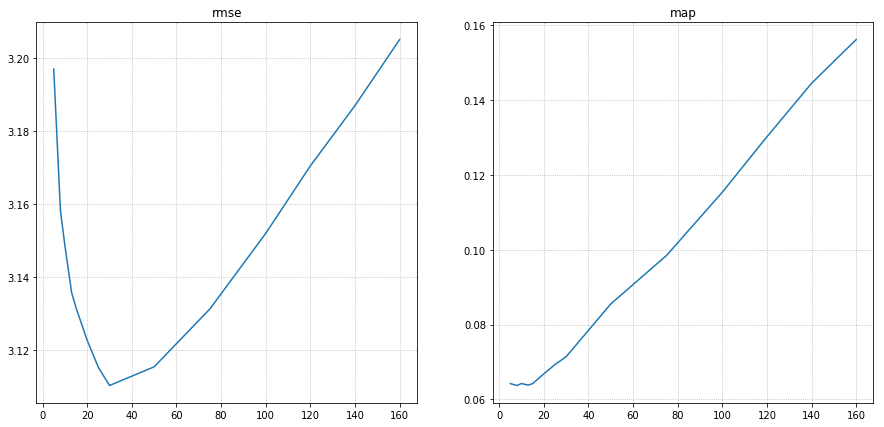

In [42]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(ranks, rmses)
plt.grid(ls=':')
plt.title('rmse')

plt.subplot(1, 2, 2)
plt.plot(ranks, maps)
plt.title('map')
plt.grid(ls=':')
plt.show()

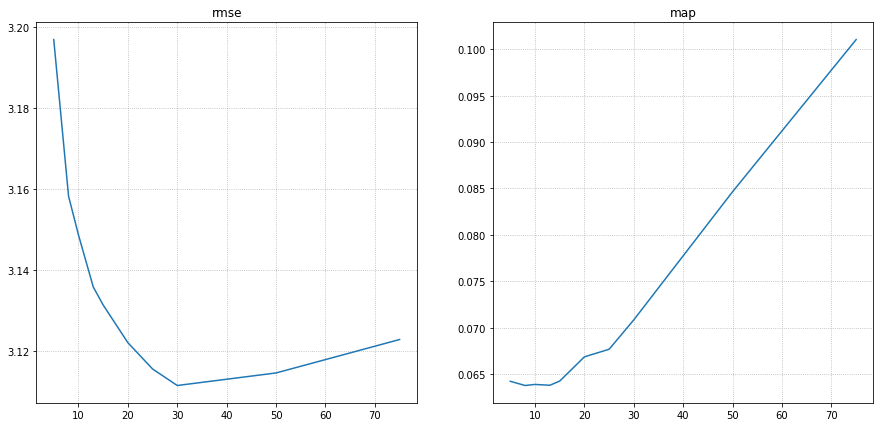

In [34]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(ranks, rmses)
plt.grid(ls=':')
plt.title('rmse')

plt.subplot(1, 2, 2)
plt.plot(ranks, maps)
plt.title('map')
plt.grid(ls=':')
plt.show()

- На основании полученных данных ответьте на вопросы: как значение ранга влияет на метрики и почему именно так?

При матричном разложении в рекомендательных системах мы говорим про то, что мы вводим некоторые темы и раскладываем нашу исходную матрицу рейтингов на 3 : матрицу распределения пользователей по темам, матрицу распределения тем и матрицу распредления фильмов по темам. Таким образом, кол-во компонент, на которое мы раскладываем - это кол-во тем, которое мы выбираем. В данном случае скорей всего темы будут неплохо напоминать жанры. <br>
Теперь посмотрим на графики. Видим, что для улучшения RMSE хорошо подходит разложение примерно на 30 тем. А вот для метрики MAP, которая смотрит не на то, какой рейтинг поставить, а в каком порядке предложить, 30 тем уже не достаточно. Кажется, что так произошло по следующей причине :  для минимизации RMSE достаточно для данного пользователя, который любит определенный жанр, поставить высокий и одинаковый рейтинг всем фильмам с этим жанром. А вот для максимизации MAP нужно еще уметь и отранжировать фильмы моего любимого жанра и поставить им все-таки разные оценки. Поэтому нужно в разы больше тем. (ну для остальных жанров также)

**Задание 4 (2 балла)** В пакете GraphLab Create также есть встроенный алгоритм рекомендации  [RankingFactorizationRecommender](https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html) ([о том как его использовать](https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.create.html#graphlab.recommender.ranking_factorization_recommender.create)). Проведите эксперименты из предыдущего задания для этого алгоритма рекомендаций, рассмотрев как влияют различные параметры на результат (поэкспериментируйте, как минимум, с 3 параметрами). Сравните результаты экспериментов с полученными ранее результатами.

Описание параметров алгоритма можно найти [здесь](https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.create.html). Мы рекомендуем при проведении экспериментов обратить внимание на некоторые из следующих параметров:
 - binary_target
 - num_factors
 - ranking_regularization
 - unobserved_rating_value
 - num_sampled_negative_examples

GraphLab перестал работать и забрал за собой весь питон( <br>
Поэтому чиним питон и переходим к следующему заданию.

### Сategorical features based approach

В этой части задания мы рассмотрим подход к рекоммендациям на основе категориальных разреженных признаков. В данном случае это id-пользователя и id-фильма, а также вам будет необходимо добавить один или несколько признаков из имеющихся данных, например: жанр фильма, киноперсоны из фильма, последний оцененный пользователем фильм, средняя оценка пользователя, ...

Для выбранного набора/наборов признаков будет необходимо построить рекомендательные системы, используя библиотеки [Vopwal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) и [LibFM](http://libfm.org). При работе с этими библиотеками не забывайте, что консольные комманды нужно исполнять прямо из ipython-notebook'а, чтобы история ваших запусков сохранилась и проверяющие могли её оценить.

#### Разреженные признаки

В данной части работы вам необходимо создать разреженную матрицу данных, закодировав каждый из категориальных признаков вектором чисел. Примером может служить следующая иллюстрация добавления различных признаков:

![](http://i.imgur.com/7nUMFx5.png)

Здесь, для наглядности, вся матрица объект-признак разбита на части, каждая из которых соответствует одному или группе категориальных признаков. Например, часть *User* соответствует закодированному признаку *user_id*, часть *Movie* — признаку *movie_id*, *Other movies rated* содержит в себе оценки пользователя другим фильмам, а *Last movie rated* соответствует признаку "последний оцененный пользователем фильм".

##### Vowpal Wabbit
С этой библиотекой вы знакомились в рамках другой лабораторной работы, где были даны подробне инструкции по ее установке и функциональности.

**Задание 5 (2 балла)**
- Создайте описанную выше выборку в формате пригодном для обучения модели с помощью Vopwal Wabbit.
- Обучите квадратичную модель на полученной выбороке c помощью Vopwal Wabbit.
- Посчитайте качество предсказаний: RMSE, MAP.

Добавим директора фильма и жанр.

In [15]:
new_data = pd.merge(data1.iloc[:,[0, 1, 2]],  data4.iloc[:,[0, 1]], how='left', on='movieID')
new_data = pd.merge(new_data, data5, how='left', on='movieID')
new_data.fillna('', inplace=True)

Приведем все к нужному формату

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
enc_data = new_data.iloc[:, [0, 1, 3, 4]]
tranformed_data = encoder.fit_transform(enc_data).toarray()

In [18]:
train_data = tranformed_data[train_indeces_frame]
test_data = tranformed_data[test_indeces_frame]

y_train = new_data.rating.values[train_indeces_frame]
y_test = new_data.rating.values[test_indeces_frame]

In [19]:
y_full = new_data.rating.values

class_val = {}
val_class = {}
for i, val in enumerate(list(set(y_full))):
    class_val[i+1] = val
    val_class[val] = i+1
    
y_train_dec, y_test_dec = list(map(lambda x: val_class[x], y_train)), list(map(lambda x: val_class[x], y_test))


def line_to_vw(line, ans='', namespace='a'):
    feat = ':1 '.join(map(str, line.indices)) + ':1'
    return '{} |{} {}\n'.format(ans,namespace,feat)

И запишем в файлы для работы

In [20]:
def write_vw_format(file, X, y=None):
    writer = open(file, 'w')
    if y is None:
        for line in X:
            writer.write(line_to_vw(line))
    else:
        for line, ans in zip(X,y):
            writer.write(line_to_vw(line, ans))
    writer.close()

In [21]:
write_vw_format('train', train_data, y_train_dec)
write_vw_format('test', test_data)

In [23]:
!head -n5 train

3 |a 14126:1 12206:1 2215:1 228:1
6 |a 14126:1 12206:1 2215:1 979:1
7 |a 14126:1 12206:1 2215:1 1446:1
5 |a 14126:1 12206:1 2215:1 747:1
6 |a 14126:1 12206:1 2215:1 4:1



In [25]:
!head -n5 test

 |a 15484:1 12199:1 11322:1 228:1
 |a 15484:1 12199:1 11322:1 1:1
 |a 15484:1 12199:1 11322:1 1691:1
 |a 15484:1 12199:1 11322:1 251:1
 |a 15484:1 12199:1 11322:1 513:1


In [26]:
! vw -d train -q aa --loss_function logistic --oaa 10 -f model


creating quadratic features for pairs: aa 
final_regressor = model
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        3        1       15
1.000000 1.000000            2            2.0        6        3       15
1.000000 1.000000            4            4.0        5        3       15
0.875000 0.750000            8            8.0        7        6       15
0.812500 0.750000           16           16.0        6        7       15
0.843750 0.875000           32           32.0        3        7       15
0.765625 0.687500           64           64.0        6        5       15
0.765625 0.765625          128          128.0        4        7       15
0.761719 0.757812          256          256.0       10        5       15
0.76

In [29]:
! vw -i model -t test -r pred

creating quadratic features for pairs: aa 
only testing
raw predictions = pred
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown        5       15
1.000000 1.000000            2            2.0  unknown        8       15
1.000000 1.000000            4            4.0  unknown        4       15
1.000000 1.000000            8            8.0  unknown        6       15
1.000000 1.000000           16           16.0  unknown        6       15
1.000000 1.000000           32           32.0  unknown       10       15
1.000000 1.000000           64           64.0  unknown        4       15
1.000000 1.000000          128          128.0  unknown        3       15
1.000000 1.000000          256          256.0  unknown       10    

Посмотрим на предсказания

In [31]:
! head -n 10 pred

1:-4.49833 2:-3.69771 3:-3.10162 4:-2.95953 5:-1.16224 6:-2.02457 7:-2.60441 8:-2.05488 9:-5.63841 10:-2.68235
1:-4.92347 2:-3.55733 3:-3.52819 4:-4.07402 5:-2.88732 6:-1.27587 7:-3.40709 8:0.666404 9:-6.59659 10:-3.25339
1:-5.94203 2:-2.32199 3:-2.99022 4:-2.65575 5:-1.50826 6:-1.64792 7:-1.8422 8:-2.74218 9:-5.719 10:-3.64538
1:-6.12905 2:-1.5929 3:-4.72433 4:-0.938805 5:-3.32301 6:-2.0532 7:-1.46273 8:-3.71281 9:-5.14548 10:-3.14067
1:-3.11774 2:-4.85997 3:-3.92992 4:-3.51362 5:-1.68983 6:-1.89628 7:-2.21026 8:-1.15879 9:-4.70976 10:-2.16177
1:-2.73775 2:-2.59766 3:-3.87783 4:-3.35435 5:-2.21765 6:-1.71773 7:-2.21006 8:-1.95513 9:-5.45706 10:-1.96278
1:-4.32519 2:-3.87469 3:-3.54254 4:-2.74432 5:-3.20498 6:-1.46454 7:-1.64464 8:-2.21449 9:-4.92673 10:-2.23626
1:-4.87592 2:-4.282 3:-3.67859 4:-2.40939 5:-2.08082 6:-1.72959 7:-1.88687 8:-2.8295 9:-4.78426 10:-2.17187
1:-3.86968 2:-2.4546 3:-2.00848 4:-2.05457 5:-2.19581 6:-2.06692 7:-2.6229 8:-2.60148 9:-3.70834 10:-3.61588
1:-2.1644 

Перепишем функцию для подсчета RMSE

In [36]:
def RMSE_(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [38]:
import re

pred_input='pred'
n, error, loss = 0, 0, 0
reader_pred = open(pred_input, 'r')

pred_scores = []

for pred in reader_pred:
    float_preds = map(float, re.split('\s*[\d]+:', pred.strip())[1:])
    float_preds = np.array(list(float_preds))

    pred = np.argmax(float_preds) + 1
    pred_scores.append(pred)

pred_scores = list(map(lambda x: class_val[x], pred_scores))
rmse = RMSE_(ytest, pred_scores)
reader_pred.close()
print(rmse)

1.105951958653035


Видим, что RMSE стало в разы меньше, классно!

#### libFm

Библиотека [libFM](http://libfm.org) реализует общий подход к задачам с категориальными признаками, в основе которого лежат факторизационные машины. В данном дистрибутиве реализованы такие методы как stochastic gradient descent ([SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)), alternating least squares ([ALS](https://arxiv.org/pdf/1206.2493.pdf)), про эти методы вам рассказывали на семинаре, а также Bayesian inference using Markov Chain Monte Carlo ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)). 
Подробную информацию можно найти в [мануале](http://www.libfm.org/libfm-1.42.manual.pdf).

libFm принимает данные в следующем формате:

    <target> <feature-id>:<feature-value> <feature-id>:<feature-value> ...

Например:

    4 0:1.5 3:-7.9
    2 1:1e-5 3:2
    -1 6:1

Если признак не указан, то он считается равным нулю. Таким образом, закодированный категориальный признак можно задать одной записью, например: 

    <user-id>:1.0
    
**Задание 6 (2 балла)**
- Создайте описанную выше выборку в формате пригодном для LibFM.
- Постройте предсказания оценок при помощи факторизационных машин, используя библиотеку LibFM. Выберете наиболее подходящий метод обучения.
- Посчитайте качество построенной модели: RMSE, MAP.

In [41]:
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

dump_svmlight_file(train_data, y_train, './train.libsvm')
dump_svmlight_file(test_data, y_test, './test.libsvm')

MCMC

In [44]:
!D:/libs/libfm/libfm-1.40.windows/libFM -task r -train train.libsvm -test test.libsvm -dim '1,1,8' -out ./libfm_mcmc.libsvm

----------------------------------------------------------------------------
libFM
  Version: 1.40
  Author:  Steffen Rendle, steffen.rendle@uni-konstanz.de
  WWW:     http://www.libfm.org/
  License: Free for academic use. See license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=849259	num_values=1698518	num_features=12146	min_target=0.5	max_target=5
Loading test... 	
has x = 0
has xt = 1
num_rows=6339	num_values=12678	num_features=3225	min_target=0.5	max_target=5
#relations: 0
Loading meta data...	
#Iter=  0	Train=2.01657	Test=3.08556
#Iter=  1	Train=0.910358	Test=2.25829
#Iter=  2	Train=0.805291	Test=1.70681
#Iter=  3	Train=0.798861	Test=1.45793
#Iter=  4	Train=0.798074	Test=1.34018
#Iter=  5	Train=0.79513	Test=1.28308
#Iter=  6	Train=0.787457	Test=1.25565
#Iter=  7	Train=0.777755	Test=1.24301
#Iter=  8	Train=0.769585	Test=1.23513
#Iter=  9	Train=0.762409	Test=1.2328
#Iter= 10	Train=0.754881	Test=1.

ALS

In [47]:
!D:/libs/libfm/libfm-1.40.windows/libFM -task r -train train.libsvm -test test.libsvm -method als -dim '1,1,8' -out ./libfm_als.libsvm

----------------------------------------------------------------------------
libFM
  Version: 1.40
  Author:  Steffen Rendle, steffen.rendle@uni-konstanz.de
  WWW:     http://www.libfm.org/
  License: Free for academic use. See license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=849259	num_values=1698518	num_features=12146	min_target=0.5	max_target=5
Loading test... 	
has x = 0
has xt = 1
num_rows=6339	num_values=12678	num_features=3225	min_target=0.5	max_target=5
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.7522	Test=1.95688
#Iter=  1	Train=0.723322	Test=1.88367
#Iter=  2	Train=0.7068	Test=1.8652
#Iter=  3	Train=0.697416	Test=1.85935
#Iter=  4	Train=0.691343	Test=1.85757
#Iter=  5	Train=0.68698	Test=1.858
#Iter=  6	Train=0.683663	Test=1.85849
#Iter=  7	Train=0.681058	Test=1.85846
#Iter=  8	Train=0.678973	Test=1.86005
#Iter=  9	Train=0.677279	Test=1.86246
#Iter= 10	Train=0.675878	Test=1.86459

С SGD не получилось :(

Смотрим на предсказания

In [61]:
mcmc_predictions = data1.iloc[test_indeces_frame].copy()
mcmc_scores = load_svmlight_file('./libfm_mcmc.libsvm')[1]

Но это еще не рейтинги, а всего лишь скоры. Давайте сначала отранжируем скоры внутри юзера и получим ранги. А потом по полученным рангам найдем рейтинг.

In [81]:
mcmc_predictions['score'] = mcmc_scores
group_scores = mcmc_pred.groupby('userID').score
mcmc_predictions['rank'] = group_scores.apply(lambda val: np.argsort(-val))

То же самое для второго метода

In [69]:
als_predictions = data1.iloc[test_indeces_frame].copy()
als_scores = load_svmlight_file('./libfm_als.libsvm')[1]
als_predictions['score'] = als_scores
group_scores = als_pred.groupby('userID').score
als_predictions['rank'] = group_scores.apply(lambda val: np.argsort(-val))

В силу того, что данные снова в другом формате. Опять реализуем метрику MAP

In [76]:
def AP(user_id, recs):
    test = data1.iloc[test_indeces_frame].movieID[(data1.iloc[test_indeces_frame].userID == user_id) & (data1.iloc[test_indeces_frame].rating > 3)].values
    rank = recs[recs.movieID.isin(test)]
    if len(rank) > 0:
        index = rel['rank'] + 1
        return (1. / len(rank) * sum(1. / index))
    return -1

def MAP_(recommendations):
    aps = [AP(user_id, group_df) for user_id, group_df in recommendations.groupby('userID')]
    good_aps = aps[aps != -1]
    return np.mean(good_aps)

Посмотрим на метрики для двух методов. Для того, чтобы посчитать MAP нам достаточно только ранга. Для посчета RMSE в качестве рейтинга возьмем ранг, умноженный на 5 / 3.

In [87]:
print(RMSE_((mcmc_pred.rank + 1) * 5 / 3 , y_test), MAP_(mcmc_pred))

2.204951654633294 0.6297439467876922


In [88]:
print(RMSE_((als_pred.rank + 1) * 5 / 3, y_test), MAP_(als_pred))

1.905452354453204 0.620708539304139


Видим, что ALS работает чуть лучше. Но разница в MAP не очень то большая.

### Statistics features based approach

В качестве иллюстрации что такое признаки-статистики или признаки-счётчики, рассмотрим категориальный признак "жанр фильма". Для каждого жанра мы можем посчитать некоторое числовое значение, например, среднее значение оценок фильмов этого жанра. Затем, если в матрице данных мы заменим значения жанров этого категориального признака на соответствующие значения средних рейтингов данных жанров, то получим новый числовой признак-счётчик.

Здесь стоит обратить внимание на следующее:

1. При создании таких счётчиков категориальных признаков по целевой переменной, важно не использовать оценки из настоящего и будущего. То есть, в нашем примере, при расчете среднего для конкретного объекта нельзя использовать как оценку текущего объекта, так и оценки, которые были поставлены позже. Иначе возникнет переобучение.
2. В качестве счётчиков можно рассматривать и другие статистики: число встречаемости данного значения, медиану целевой переменной по объектам с тем же значением данного категориального признака и т.п.
3. Подобные признаки-счётчики можно считать не только по одному категориальному признаку, как в примере с жанром фильма, но и и по набору из нескольких категориальных признаков, например, по паре (жанр, киноперсоны).
4. Счётчики можно считать не только по целевой переменной, но и относительно других признаков.

**Задание 7 (3 балла)**
- Используя исходные данные, создайте выборку с набором признаков-счётчиков.
- На полученной выборке с счетчиками постройте предсказания оценок, используя [xgboost](https://github.com/dmlc/xgboost) или [catboost](https://tech.yandex.com/catboost/doc/dg/concepts/about-docpage). Постарайтесь добиться качества сравнимого с качеством моделей из предыдущего пункта.

- Какие признаки-счётчики оказались наиболее удачными? Почему? 

**Задание 8 (1 балл)** Приведите сравнение качества всех моделей, использованных в работе, руководствуясь значениями описанных метрик. Какие из моделей оказались лучше других по каждой из метрик? Чем это можно объяснить?

## Адаптивное обучение

В рамках следующего задания предлагается сравнить две стратегии расширения размеченной выборки для улучшения качества рекомендаций: случайную и основанную на разбросе предсказаний обученного алгоритма.

**Задание 9 (2 балла)** Проведите следующий эксперимент:
- Разбейте исходный датасет на обучающую выборку $A$ и тестовую выборку $B$ так, чтобы в обучающую выборку вошли хронологически первые 70% всех оценок пользователей, а в тестовую хронологически последние 30%.
- Обучите один из рассмотренных выше алгоритмов рекомендаций на случайных 10% обучающей выборки $A$ (подвыборке $A_1$) и оцените качество этого алгоритма на тестовой выборке $B$. Затем проделайте то же самое ещё 9 раз: каждый раз расширяя выборку случайными объектами до 20% ($A_2$), 30% ($A_3$), ..., 100% ($A_{10} == A$) обучающей выборки, пока не заиспользуете все 70% от исходной выборки.
- Проделайте эксперимент из предыдущего пункта, каждый раз расширяя выборку $A_i$ для обучения не случайными 10% объектами, а объектами из оставшейся части обучающей выборки $(A$ \ $A_i)$ с наибольшим разбросом предсказаний модели, обученной на $A_i$. Разброс предсказаний модели считайте как разброс предсказаний моделей, обученных с помощью бутстрепа обучающих данных $A_i$. Таким образом всего вы должны обучить $N$ моделей (где $N$ — количество итераций бутстрепа) для каждого из 10 размеров обучающих выборок (10%, 20%, ..., 100%).
- Проделайте предыдущие 2 пункта несколько раз, затем постройте и сравните между собой графики качества на тестовом датасете в зависимости от размера обучащей выборки в случае обеих стратегий.

Важно отметить, что описанный выше эксперимент **учебный** и не совсем корректный, так как, при генерации обучающих выборок, мы пренебрегаем хронологией пользовательских оценок.